In [2]:
# activate oxygen_transport environment


import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.dates import DateFormatter, MonthLocator
import matplotlib.dates as mdates
import matplotlib.colors as colors
from datetime import datetime, timedelta
import scipy
import dask
from dask import delayed, compute
from dask.distributed import Client
import dask.bag as db
import gc
import matplotlib.gridspec as gridspec

import seaborn as sns
sns.set_theme(style="whitegrid")

# Import data

In [3]:


osnap_daily = xr.open_dataset(r'C:\Users\bikbe\Documents\Projects\GOHSNAP\Data\Yao velocity grid uncertainty\daily_2020_2022.nc') #daily osnap grids
osnap_daily['TIME'] = pd.to_datetime(osnap_daily.TIME - 719529, unit='D')

osnap = xr.open_dataset(r'C:\Users\bikbe\Documents\Projects\GOHSNAP\Data\O2 transport\OSNAP_2014-2022\OSNAP_Gridded_TSV_201408_202207_2025.nc') #monthly osnap grids
osnap = osnap.sel(LONGITUDE = slice(osnap.LONGITUDE[0], osnap.LONGITUDE[77])).sel(TIME = slice(osnap_daily.TIME[0], osnap_daily.TIME[-1])) #limit to only Labrador Sea

oxygen_grid = xr.open_dataset(r'C:\Users\bikbe\Documents\Projects\GOHSNAP\Data\Ellen RF Grid\gohsnap_doxy_wbias_June16.nc') # oxygen grid



# Calculate oxygen transport with uncertainty

### OSNAP added a small value to each velocity measurment to force the flux grid to sum to 1.6 Sv, the volume flux through Davis Straight. We must do the same to force the flux grid to sum to 0 Sv. 

In [4]:
#Example sum to 1.6 Sv
print((osnap_daily.sel(TIME = osnap_daily.TIME[2]).velocity * osnap_daily.grid_factor).sum().values*1e-6) #example daily grid
print(np.nansum(osnap.sel(TIME = osnap.TIME[3]).VELO.values * osnap_daily.grid_factor.values)*1e-6) #example monthly grid


-1.6002556559684964
-1.7355045911447506


In [5]:
# Find small adjustment value that brings monthly volume flux sum to zero. Takes a long time to run, so I saved outputs in following cell.


# osnap_old = xr.open_dataset(r'C:\Users\bikbe\Documents\Projects\GOHSNAP\Data\O2 transport\O2_mol_yr_Oct_19_amoc_isopycnal_with_dx_and_velocity.nc')

# correction = []

# for i in np.arange(len(osnap.TIME)): #for each month
    
#     d = 50
#     correction_guess = np.linspace(-0.001,0.001)

#     print(i)
#     #i = 5
#     while np.abs(d) > 5: #stop when sum is less than 1 m^3/s (or equivalently, 1e-6 Sv)
                
#                 tmp = []  
#                 for ii in correction_guess:
                    
#                     tmp.append(np.nansum((osnap.sel(TIME = osnap.TIME[i]).VELO.values + ii) * osnap_daily.grid_factor.values))   
#                     #tmp.append(np.nansum((osnap_old.sel(time = osnap_old.time[i]).velocity_uncorrected.values + ii) * osnap_daily.grid_factor.values))   
        
#                 ix = np.argmin(np.abs(tmp))
#                 d = np.nanmin(np.abs(tmp))
#                 correction_tmp = correction_guess[ix]
#                 print(i,ix,d)
#                 correction_guess = np.linspace(correction_guess[ix] - 0.00000001 , correction_guess[ix] + 0.00000001)

#     correction.append(correction_tmp)


#     gc.collect()
    

In [ ]:
correction = np.array([0.0005448044897958878, #calculated in cell above
    0.0005678051020408986,
    0.0005586595918367722,
    0.0005895271428571315,
    0.000570863061224587,
    0.0005378961224489152,
    0.00054382040816323,
    0.0005601004081633098,
    0.0005668938775510983,
    0.0005608234693878032,
    0.0005774367346938068,
    0.0005625926530612812,
    0.0005569304081632943,
    0.0005452412244897675,
    0.0005418004081632201,
    0.0005679304081633482,
    0.0005790020408162635,
    0.0005472948979591654,
    0.0005777779591836044,
    0.0005826728571428121,
    0.0006176346938774774,
    0.0006621067346938218,
    0.0006441193877551583,
    0.0006289442857142676])



In [ ]:
# Apply adjustment to each monthly velocity grid 

tmp = []
for i in np.arange(24):
    tmp.append(osnap.sel(TIME = osnap.TIME[i]).VELO + correction[i]) 

osnap['VELO_ZEROSUM'] = (['TIME', 'DEPTH', 'LONGITUDE'], tmp)

# Calculate volume flux and add to dataset

osnap['VOL_FLUX'] = osnap.VELO_ZEROSUM * osnap_daily.grid_factor.values


In [ ]:
# test that each month sums to close to 0 m^3/s transport (note units are m^3/s, NOT Sv)

osnap.VOL_FLUX.sum(dim = 'LONGITUDE').sum(dim='DEPTH')

<xarray.DataArray 'VOL_FLUX' (TIME: 24)>
array([ 0.22806086,  0.08193792, -0.05661578, -2.16433284,  0.4879377 ,
        0.19903428,  0.44142243, -0.80377696,  0.32873165, -0.35350377,
       -0.17284631, -0.13614934, -4.02229739,  1.12820252,  1.44127695,
       -0.81953755,  0.12196262, -0.31455479,  0.36567961, -0.27091807,
        0.75811015, -0.36932843, -0.20825018, -1.0075514 ])
Coordinates:
  * TIME     (TIME) datetime64[ns] 2020-08-01T12:00:00 ... 2022-07-01T12:00:00

### Calculate oxygen transport

$
 T =   \int_{x_w}^{x_e} \int_{z_{min}}^{z_{max}} O_{2} \, v \, dz \, dx
$

Text(0, 0.5, 'Oxygen transport [Tmol/yr]')

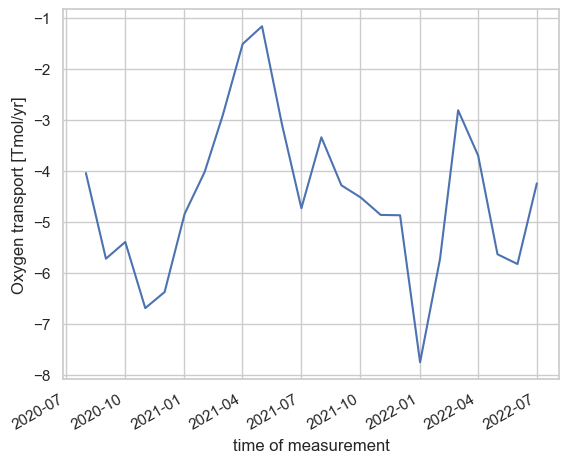

In [9]:
# multiply volume flux in m^3/s by oxygen grid in mol/m^3
# convert from oxygen grid in umol/kg to mol/m^3 by multiplying by density 
# add DSOW bias correction
# convert from mol/y to Tmol/yr: * 1e-6 * 3.15576e+7 *1e-12 

osnap['OXY_TRANSPORT'] = osnap.VOL_FLUX * (oxygen_grid.DOXY*oxygen_grid.SIGMA0 + oxygen_grid.DOXY_BIAS_WOA*oxygen_grid.SIGMA0).values * 1e-6 * 3.15576e+7 *1e-12 

osnap.OXY_TRANSPORT.sum(dim = 'LONGITUDE').sum(dim='DEPTH').plot()
plt.ylabel('Oxygen transport [Tmol/yr]')

### Calculate integral time scale of daily velocity

In [10]:


def autocorrelation(x):
    """Calculate the autocorrelation function of a 1D array."""
    n = len(x)
    x = x - np.nanmean(x)
    result = np.correlate(x, x, mode='full') / np.nanvar(x) / n #normalize by variance. Division by n accounts for overlapping points, produces avreage correlation at each lag instead of sum
    return result[n - 1:] #splits at the maximum

def integral_time_scale(time_series, sampling_interval=1):
    """
    Calculate the integral time scale for each (depth, distance) location
    in a 3D time series (time, depth, distance).
    """
    n_depths = time_series.shape[1]
    n_distances = time_series.shape[2]
    
    # Initialize array
    integral_time_scales = np.zeros((n_depths, n_distances))
    
    # Loop over each depth and distance
    for i in range(n_depths):
        for j in range(n_distances):
            # Get the time series for this (depth, distance) location
            ts = time_series[:, i, j]
            ts = pd.Series(ts).interpolate(method='linear', limit_direction='both').to_numpy() #interpolate over nans
            # Compute the autocorrelation


            acf = autocorrelation(ts)


            # Check if there is any zero crossing
            
            tmp = acf #check whole time series
            zero_crossing = np.argwhere(tmp<0)

            if zero_crossing.size > 0:
                zero_crossing = np.argwhere(tmp<0)[0][0] #first point where reaches zero
                
            else:
                zero_crossing = len(acf) #defaults to length of time series

            integral_time = np.trapz(acf[:zero_crossing + 1]) #take integral up to zero crossing point
            
            # Convert to physical time units
            integral_time_scales[i, j] = integral_time * sampling_interval #1 day for daily grid
    
    return integral_time_scales

tau = integral_time_scale(osnap_daily.velocity)

C:\Users\bikbe\AppData\Local\Temp\ipykernel_32868\3121047938.py:4: RuntimeWarning: Mean of empty slice
  x = x - np.nanmean(x)
C:\Users\bikbe\AppData\Local\Temp\ipykernel_32868\3121047938.py:5: RuntimeWarning: Degrees of freedom <= 0 for slice.
  result = np.correlate(x, x, mode='full') / np.nanvar(x) / n #normalize by variance. Division by n accounts for overlapping points, produces avreage correlation at each lag instead of sum


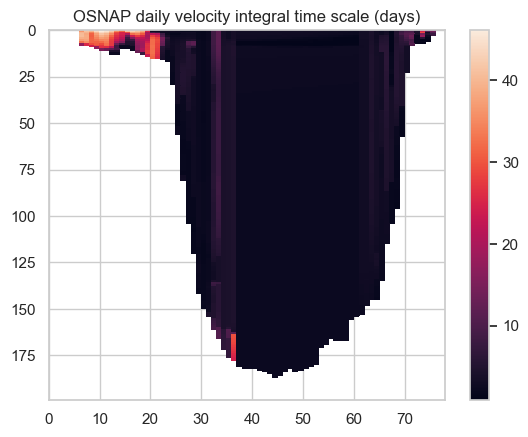

In [11]:
plt.title('OSNAP daily velocity integral time scale (days)')
plt.pcolor(tau)
plt.gca().invert_yaxis()
plt.colorbar()

### Estimate uncertainties with Monte Carlo

In [ ]:

#https://statisticsbyjim.com/probability/monte-carlo-simulation/

tmp2=[] 

tmp3=[] 

tmp4 = []

for ii in np.arange(100): #50000
    tmp = []
    tmp_a = []
    tmp_b = []

    days_in_month = osnap_daily.velocity.resample(TIME='M').count().max(dim = 'DEPTH').max(dim = 'LONGITUDE')
    V_std = osnap_daily.velocity.resample(TIME='M').std()

    #err_ratio_full = osnap_daily.velocity.resample(TIME='M').std()/osnap_daily.velocity.resample(TIME='M').mean().values

    for i in np.arange(24):

        # oxygen grid with DSOW correciton added. Multiplied by density to convert from umol/kg to umol/m3
        oxygen = (oxygen_grid.DOXY.sel(TIME = oxygen_grid.TIME[i]).values + oxygen_grid.DOXY_BIAS_WOA.sel(TIME = oxygen_grid.TIME[i].values))*oxygen_grid.SIGMA0.sel(TIME = oxygen_grid.TIME[i]).values #osnap.sel(time = osnap.time[i+1]).rho0.values#
        oxygen_error = oxygen_grid.DOXY_ERROR_TOTAL.sel(TIME = oxygen_grid.TIME[i]).values*oxygen_grid.SIGMA0.sel(TIME = oxygen_grid.TIME[i]).values #osnap.sel(time = osnap.time[i+1]).rho0.values#
        #oxy_montecarlo = np.random.normal(oxygen, oxygen_error) # select random grid realization from normal distribution
        oxy_montecarlo = oxygen + oxygen_error*np.random.normal(size=oxygen.shape)
        
        #vflux = (osnap_daily.flux_m3_s_velo_corrected).sel(time = timeslice).mean(dim='time') #average daily volume flux grid over month. 
        V = osnap.VELO_ZEROSUM.sel(TIME = osnap.TIME[i]) 
        V_error = V_std.sel(TIME = V_std.TIME[i])/np.sqrt(days_in_month[i].values/(2*tau))
        V_error = V_error.where(np.abs(V_error)<1) #cap error at 100%
        
        V_montecarlo = V + V_error.values*np.random.normal(size=V.shape)
        #V_montecarlo = V + V_std_error.values*np.random.randn(1)

        #O2_transport = ((oxy_montecarlo*1e-6 * V_montecarlo * osnap_daily.grid_factor.values.reshape(1,78)) * 3.15576e+7)*1e-12 

        O2_transport = ((oxy_montecarlo.values*1e-6 * V_montecarlo.values * osnap_daily.grid_factor.values.reshape(1,78)) * 3.15576e+7)*1e-12 
        

        V_transport = ((V_montecarlo.values * osnap_daily.grid_factor.values.reshape(1,78))) * 1e-6  


        tmp.append(np.nansum(O2_transport))

        tmp_b.append(np.nansum(V_transport))
        
    tmp2.append(tmp)

    tmp3.append(tmp_a)

    tmp4.append(tmp_b)

    if ii % 10 == 0:
        gc.collect()

    if ii % 100 == 0:
        print(ii)
#plt.plot(tmp2)
print(np.nanmean(tmp2))
print(np.nanstd(tmp2))

c:\Users\bikbe\anaconda3\envs\oxygen_transport\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\bikbe\anaconda3\envs\oxygen_transport\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\bikbe\anaconda3\envs\oxygen_transport\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\bikbe\anaconda3\envs\oxygen_transport\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\bikbe\anaconda3\envs\oxygen_transport\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanv

0


c:\Users\bikbe\anaconda3\envs\oxygen_transport\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\bikbe\anaconda3\envs\oxygen_transport\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\bikbe\anaconda3\envs\oxygen_transport\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\bikbe\anaconda3\envs\oxygen_transport\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\bikbe\anaconda3\envs\oxygen_transport\Lib\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanv

-4.383220656146747
4.383281198558856


In [13]:
d = 5
correction = []

tmp = []
d = 50
correction_guess = np.linspace(-0.001,0.001)

print(i)
#i = 5
while np.abs(d) > 5: #stop when sum is less than 1 m^3/s (or equivalently, 1e-6 Sv)
            
            tmp = []  
            for ii in correction_guess:
                
                tmp.append(np.nansum((V_montecarlo + ii) * osnap_daily.grid_factor.values))   
                #tmp.append(np.nansum((osnap_old.sel(time = osnap_old.time[i]).velocity_uncorrected.values + ii) * osnap_daily.grid_factor.values))   
    
            ix = np.argmin(np.abs(tmp))
            d = np.nanmin(np.abs(tmp))
            correction_tmp = correction_guess[ix]
            print(i,ix,d)
            correction_guess = np.linspace(correction_guess[ix] - 0.00000001 , correction_guess[ix] + 0.00000001)

correction.append(correction_tmp)


23
23 8 8906.49275006866
23 49 8877.053913261509
23 49 8847.615076456219
23 49 8818.176239653258
23 49 8788.7374028489
23 49 8759.29856604617
23 49 8729.859729238553
23 49 8700.420892433263
23 49 8670.98205562844
23 49 8641.543218825944
23 49 8612.104382020188
23 49 8582.665545214433
23 49 8553.22670840961
23 49 8523.78787160595
23 49 8494.349034802988
23 49 8464.910197996767
23 49 8435.471361191478
23 49 8406.032524388283
23 49 8376.593687582761
23 49 8347.154850777239
23 49 8317.716013973346
23 49 8288.277177164797
23 49 8258.838340363
23 49 8229.399503557011
23 49 8199.960666754516
23 49 8170.521829949925
23 49 8141.082993146498
23 49 8111.644156340277
23 49 8082.205319535453
23 49 8052.766482730396
23 49 8023.327645926969
23 49 7993.888809122145
23 49 7964.449972315226
23 49 7935.011135509703
23 49 7905.572298706975
23 49 7876.133461903781
23 49 7846.694625098724
23 49 7817.255788292503
23 49 7787.8169514869805
23 49 7758.378114684485
23 49 7728.939277878497
23 49 7699.500441073906

In [14]:

d = 1e10
correction_guess = np.linspace(-0.001,0.001)


#i = 5
while np.abs(d) > 10000: #stop when sum is less than 1 m^3/s (or equivalently, 1e-6 Sv)
            
            tmp_sum = []  
            for c_i in correction_guess:
                
                tmp_sum.append(np.nansum((V_montecarlo + c_i) * osnap_daily.grid_factor.values))   
                
    
            ix = np.argmin(np.abs(tmp_sum))
            d = np.nanmin(np.abs(tmp_sum))
            correction = correction_guess[ix]
            
            correction_guess = np.linspace(correction_guess[ix] - 0.0001 , correction_guess[ix] + 0.0001)

            print(d)

while np.abs(d) > 50: #stop when sum is less than 1 m^3/s (or equivalently, 1e-6 Sv)
            
            tmp_sum = []  
            for c_i in correction_guess:
                
                tmp_sum.append(np.nansum((V_montecarlo + c_i) * osnap_daily.grid_factor.values))   
                
    
            ix = np.argmin(np.abs(tmp_sum))
            d = np.nanmin(np.abs(tmp_sum))
            correction = correction_guess[ix]
            
            correction_guess = np.linspace(correction_guess[ix] - 0.00000001 , correction_guess[ix] + 0.00000001)

            print(d)

8906.49275006866
2898.566871582996
2869.1280347802676
2839.689197974978
2810.2503611692227
2780.811524362769
2751.372687560506
2721.933850757312
2692.495013952721
2663.056177145103
2633.617340340279
2604.1785035373177
2574.739666732494
2545.3008299283683
2515.8619931205176
2486.423156318022
2456.9843195122667
2427.545482709771
2398.1066459040157
2368.66780910152
2339.228972293902
2309.7901354883797
2280.35129868472
2250.912461878732
2221.4736250760034
2192.034788268851
2162.59595146426
2133.1571146617644
2103.7182778583374
2074.279441052582
2044.8406042463612
2015.401767442003
1985.9629306374118
1956.524093833752
1927.0852570284624
1897.6464202210773
1868.2075834174175
1838.7687466142233
1809.3299098103307
1779.8910730048083
1750.4522361988202
1721.0133993953932
1691.5745625905693
1662.1357257859781
1632.6968889804557
1603.2580521774944
1573.8192153708078
1544.3803785650525
1514.9415417625569
1485.5027049598284
1456.0638681547716
1426.6250313490164
1397.1861945423298
1367.7473577382043

In [15]:
# Don't need to run, just load output

# #https://statisticsbyjim.com/probability/monte-carlo-simulation/

# # tmp2=[] 

# # tmp3=[] 

# # tmp4 = []

# for ii in np.arange(500): #50000
#     tmp = []
#     tmp_a = []
#     tmp_b = []

#     days_in_month = osnap_daily.velocity.resample(TIME='M').count().max(dim = 'DEPTH').max(dim = 'LONGITUDE')
#     V_std = osnap_daily.velocity.resample(TIME='M').std()

#     #err_ratio_full = osnap_daily.velocity.resample(TIME='M').std()/osnap_daily.velocity.resample(TIME='M').mean().values

#     for i in np.arange(24):
        
#         # oxygen grid with DSOW correciton added. Multiplied by density to convert from umol/kg to umol/m3
#         oxygen = (oxygen_grid.DOXY.sel(TIME = oxygen_grid.TIME[i]).values + oxygen_grid.DOXY_BIAS_WOA.sel(TIME = oxygen_grid.TIME[i].values))*oxygen_grid.SIGMA0.sel(TIME = oxygen_grid.TIME[i]).values #osnap.sel(time = osnap.time[i+1]).rho0.values#
#         oxygen_error = oxygen_grid.DOXY_ERROR_TOTAL.sel(TIME = oxygen_grid.TIME[i]).values*oxygen_grid.SIGMA0.sel(TIME = oxygen_grid.TIME[i]).values #osnap.sel(time = osnap.time[i+1]).rho0.values#
#         #oxy_montecarlo = np.random.normal(oxygen, oxygen_error) # select random grid realization from normal distribution
#         oxy_montecarlo = oxygen + oxygen_error*np.random.normal()
        
#         #vflux = (osnap_daily.flux_m3_s_velo_corrected).sel(time = timeslice).mean(dim='time') #average daily volume flux grid over month. 
#         V = osnap.VELO.sel(TIME = osnap.TIME[i]) 
#         V_error = V_std.sel(TIME = V_std.TIME[i])/np.sqrt(days_in_month[i].values/(2*tau))
#         #V_error = V_error.where(np.abs(V_error)<1) #cap error at 100%
        
#         #V_montecarlo = V + V_error.values*np.random.normal(size=V.shape)
#         V_montecarlo = V + V_error.values*np.random.normal()

#         # Volume flux must sum to zero      
        
#         d = 1e10
#         correction_guess = np.linspace(-0.001,0.001)


#         #i = 5
#         while np.abs(d) > 10000: #stop when sum is less than 1 m^3/s (or equivalently, 1e-6 Sv)
                    
#                     tmp_sum = []  
#                     for c_i in correction_guess:
                        
#                         tmp_sum.append(np.nansum((V_montecarlo + c_i) * osnap_daily.grid_factor.values))   
                        
            
#                     ix = np.argmin(np.abs(tmp_sum))
#                     d = np.nanmin(np.abs(tmp_sum))
#                     correction = correction_guess[ix]
                    
#                     correction_guess = np.linspace(correction_guess[ix] - 0.0001 , correction_guess[ix] + 0.0001)

                    
#         max_iter = 1000
#         n_iter = 0
        
#         while np.abs(d) > 50 and n_iter < max_iter: #stop when sum is less than 1 m^3/s (or equivalently, 1e-6 Sv)
#                     n_iter += 1
#                     tmp_sum = []  
#                     for c_i in correction_guess:
                        
#                         tmp_sum.append(np.nansum((V_montecarlo + c_i) * osnap_daily.grid_factor.values))   
                        
            
#                     ix = np.argmin(np.abs(tmp_sum))
#                     d = np.nanmin(np.abs(tmp_sum))
#                     correction = correction_guess[ix]
                    
#                     correction_guess = np.linspace(correction_guess[ix] - 0.00000001 , correction_guess[ix] + 0.00000001)

                    
#         # def flux_sum(c):
#         #     return np.nansum((V_montecarlo + c) * osnap_daily.grid_factor.values)

#         # try:
#         #     correction = brentq(flux_sum, -0.01, 0.01)  # bounds must bracket the root
#         # except ValueError:
#         #     correction = 0  # fallback if root not bracketed

        
    

#         O2_transport = ((oxy_montecarlo.values*1e-6 * (V_montecarlo.values + correction) * osnap_daily.grid_factor.values.reshape(1,78)) * 3.15576e+7)*1e-12 
        
#         O2_transport_oxy_only = ((oxy_montecarlo.values*1e-6 * V * osnap_daily.grid_factor.values.reshape(1,78)) * 3.15576e+7)*1e-12  # error due to oxygen only

#         V_transport = (((V_montecarlo.values + correction)  * osnap_daily.grid_factor.values.reshape(1,78))) * 1e-6  # error due to oxygen only


#         tmp.append(np.nansum(O2_transport))
#         tmp_a.append(np.nansum(O2_transport_oxy_only))
#         tmp_b.append(np.nansum(V_transport))
        
#     tmp2.append(tmp)

#     tmp3.append(tmp_a)

#     tmp4.append(tmp_b)

#     if ii % 2 == 0:
    
#         gc.collect()

#     if ii % 1 == 0:
#         print(ii)
# #plt.plot(tmp2)
# print(np.nanmean(tmp2))
# print(np.nanstd(tmp2))

# np.savetxt(r'C:\Users\bikbe\Documents\Projects\GOHSNAP\Data\O2 transport\monthly_transport.csv',tmp2)

In [16]:
tmp2 = np.loadtxt(r'C:\Users\bikbe\Documents\Projects\GOHSNAP\Data\O2 transport\monthly_transport.csv')
tmp2

array([[-4.50653575, -6.21705309, -3.87404836, ..., -7.17375992,
        -5.32242532, -4.02687914],
       [-3.49819601, -6.23831981, -5.99007608, ..., -6.80303308,
        -7.62494253, -7.39275442],
       [-4.26854368, -6.13571462, -4.60497595, ..., -9.74134709,
        -5.87007149, -4.14088718],
       ...,
       [-3.59292141, -6.46312285, -4.70528019, ..., -0.92198362,
        -6.4296224 ,  6.50884089],
       [-4.5722172 , -5.88124497, -4.87374619, ..., -3.22636092,
        -7.16575157, -2.67527475],
       [-3.95754167, -5.90257091, -5.47848546, ..., -3.39224709,
        -6.81468664, -4.82031897]])

## Figure 4

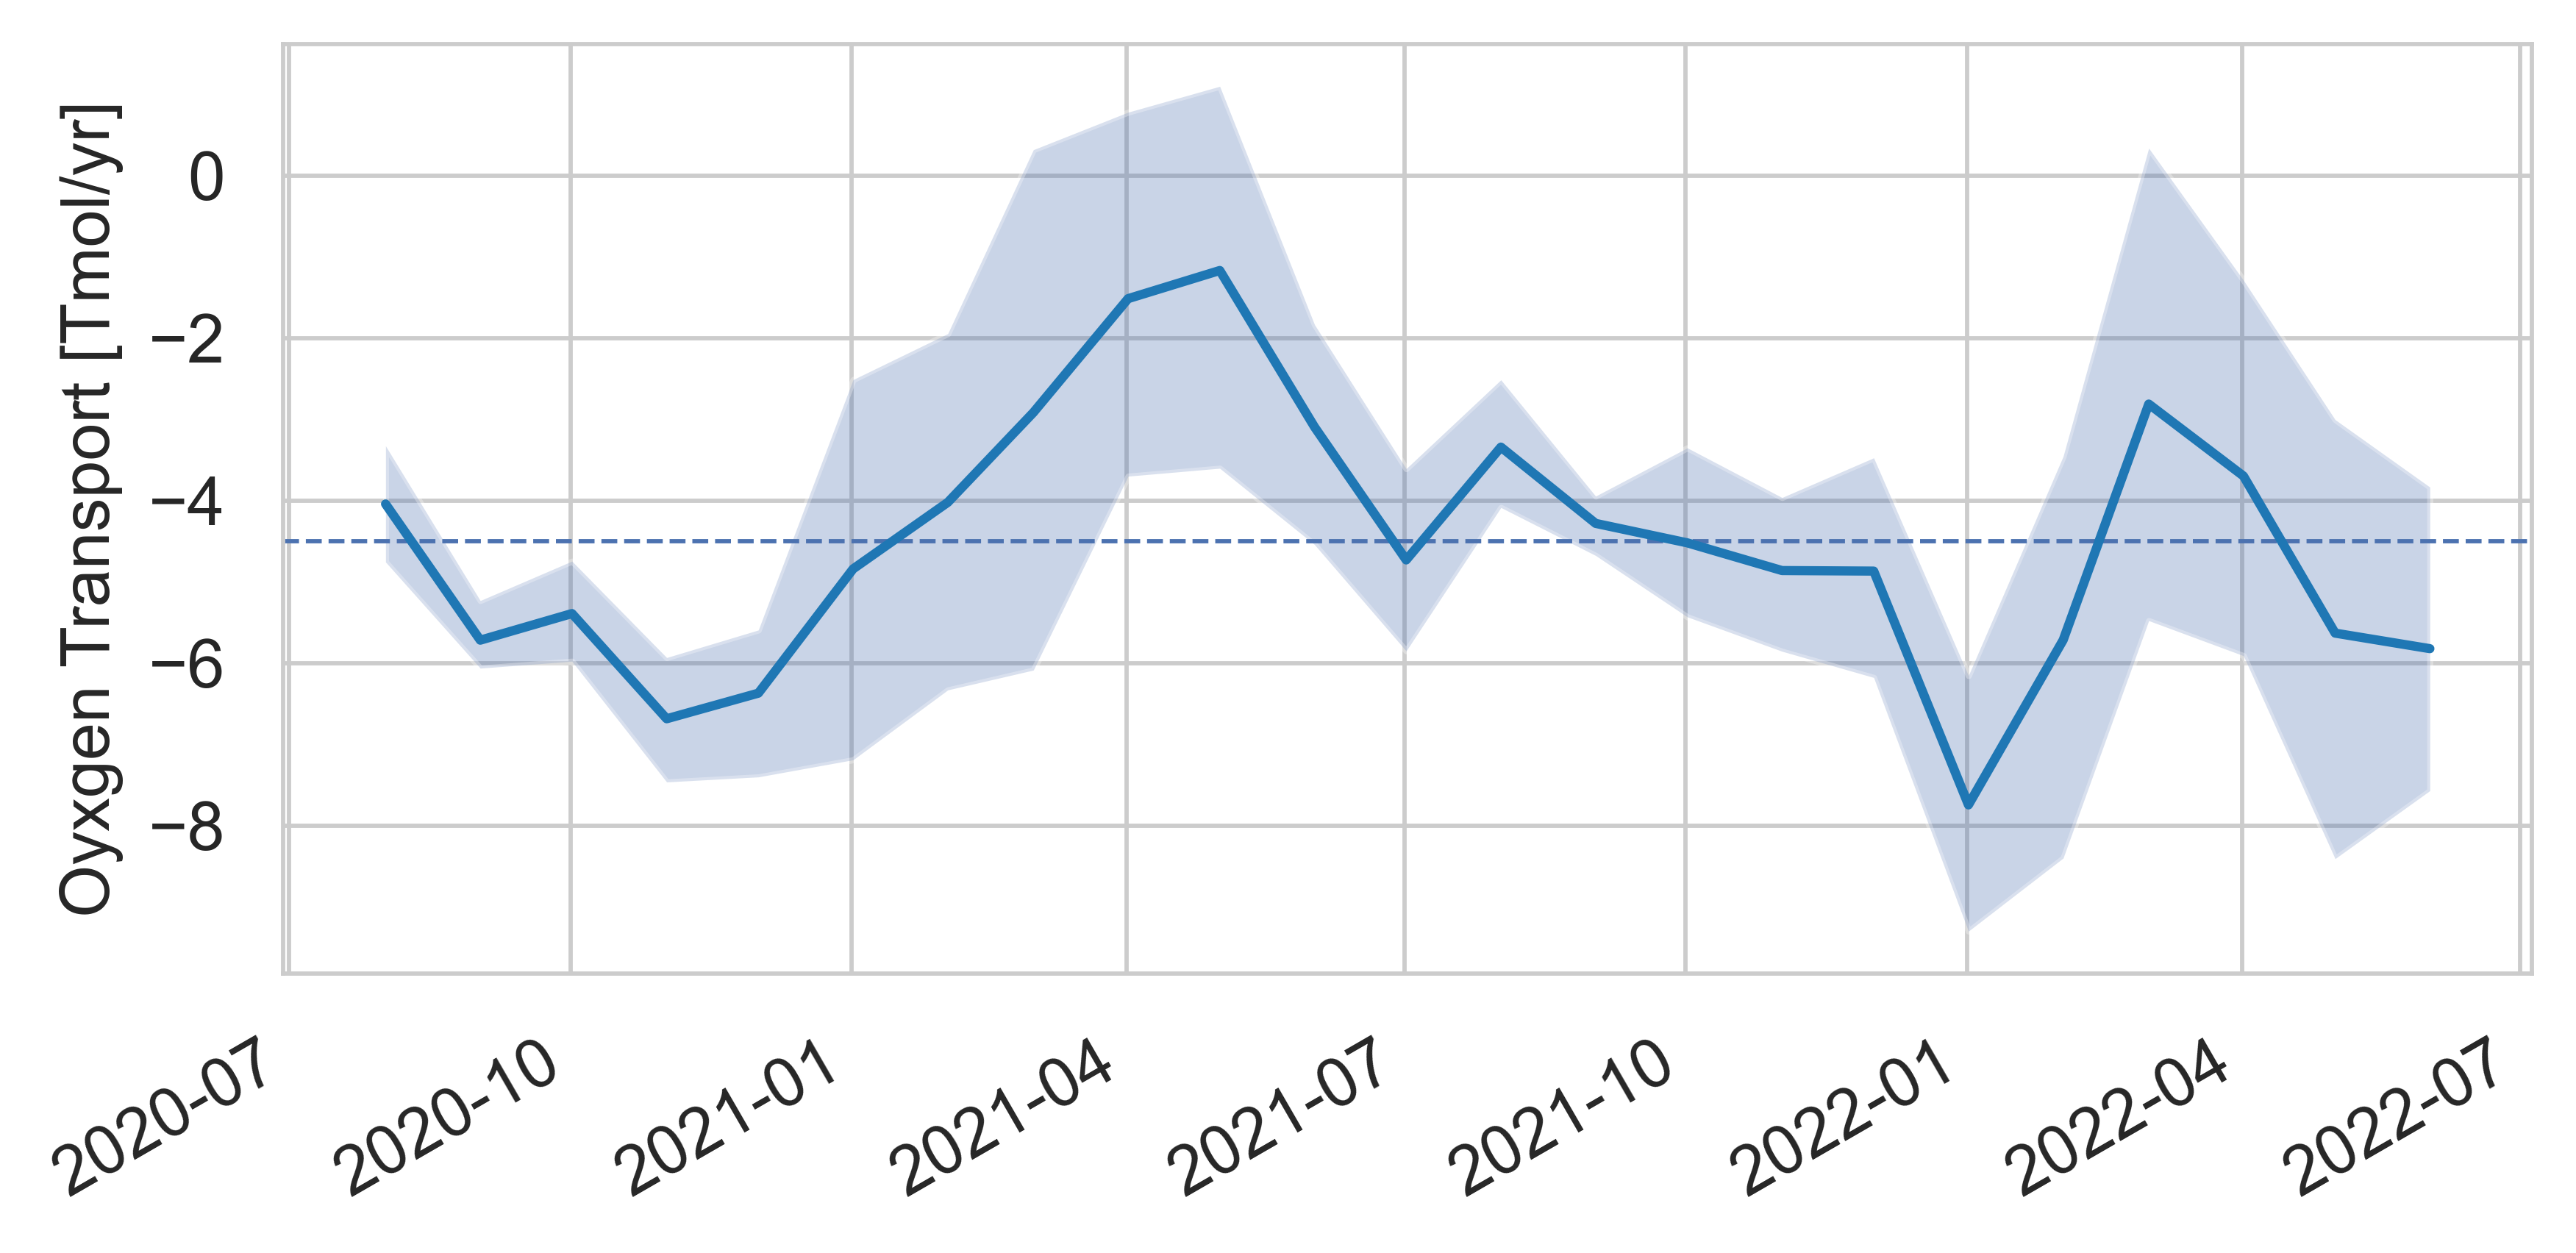

In [27]:
import matplotlib as mpl

mpl.rcParams['axes.linewidth'] = 0.7

plt.figure(figsize=(6, 3), dpi=600) 


plt.fill_between(osnap.TIME[:-1],np.nanmean(tmp2,axis = 0)[:-1] - np.nanstd(tmp2,axis = 0)[:-1], np.nanmean(tmp2,axis = 0)[:-1] + np.nanstd(tmp2,axis = 0)[:-1], alpha = 0.3)
# plt.fill_between(osnap.TIME[:-1],np.nanmean(tmp3,axis = 0)[:-1] - np.nanstd(tmp3,axis = 0)[:-1], np.nanmean(tmp3,axis = 0)[:-1] + np.nanstd(tmp3,axis = 0)[:-1], 
#                  edgecolor='none', linewidth=0, alpha = 0.3, zorder = 2)

#plt.plot(osnap.TIME[:-1],np.nanmean(tmp2,axis = 0)[:-1] , color ='tab:orange')

plt.axhline(np.nanmean(tmp2[:-1]), linewidth = 0.7, linestyle = 'dashed')
#plt.plot(osnap.TIME[:-1],np.nanmean(tmp2,axis = 0)[:-1], color='tab:orange' )
osnap.TIME[:-1],osnap.OXY_TRANSPORT.sum(dim = 'LONGITUDE').sum(dim='DEPTH')[:-1].plot( color = 'tab:blue')

plt.ylabel('Oyxgen Transport [Tmol/yr]', fontsize = 11)


# plt.fill_between(osnap.TIME,np.nanmean(isopycnal_transport,axis = 0)[:,-1] - np.nanstd(isopycnal_transport,axis = 0)[:,-1], np.nanmean(isopycnal_transport,axis = 0)[:,-1] + np.nanstd(isopycnal_transport,axis = 0)[:,-1],alpha = 0.3)
# plt.plot(osnap.TIME,np.nanmean(isopycnal_transport,axis = 0)[:,-1], color = 'tab:orange')

#plt.fill_between(osnap.TIME,np.nanmean(overturning_transport,axis = 0)[:,-1] - np.nanstd(overturning_transport,axis = 0)[:,-1], np.nanmean(overturning_transport,axis = 0)[:,-1] + np.nanstd(overturning_transport,axis = 0)[:,-1],alpha = 0.3)
#plt.plot(osnap.TIME,np.nanmean(overturning_transport,axis = 0)[:,-1], color = 'tab:green')

#plt.plot(osnap.TIME,np.nanmean(overturning_transport,axis = 0)[:,-1] + np.nanmean(isopycnal_transport,axis = 0)[:,-1], color = 'tab:green')

#plt.axhline(0, color = 'grey', linewidth = 0.7)
plt.grid(linewidth=0.7)
plt.xlabel('')

plt.tight_layout()

plt.savefig(r'C:\Users\bikbe\Documents\Projects\GOHSNAP\Figures\Transport manuscript\transport_uncertainties.png')

In [ ]:
print('24-month average net transport: '+ str(np.nanmean(np.nanmean(tmp2,axis = 0)[:-1])))
print('24-month standard devation: ' + str(np.nanmean(np.nanstd(tmp2,axis = 0)[:-1])))

24-month average net transport: -4.508069336154123
24-month standard devation: 1.5896317644231877


# Calculate overturning and isopycnal componants

### Regrid in density space

In [28]:
# #don't need to run, just load output

# V_global = osnap.VELO_ZEROSUM#.isel(time=slice(1, None))
# V_error_global = osnap_daily.velocity.resample(TIME='M').std()/np.sqrt(30/(2*tau))
# bins_rho0 = np.arange(1024.53, 1027.95, 0.01)

# O_global = (oxygen_grid.DOXY + oxygen_grid.DOXY_BIAS_WOA)*oxygen_grid.SIGMA0 #convert from umol/kg to umol/m3 by multiplying by density
# O_error_global = oxygen_grid.DOXY_ERROR_TOTAL



# #overturning_transport = []
# #isopycnal_transport = []


# for it in np.arange(100):

    
#     if it % 2 == 0:
        
#         gc.collect()
    
#     if it % 5 == 0:
#         print(f"Starting iteration {it}")
        

    

    
#     #counts = np.zeros([78,len(bins_rho0),24])
#     #velo_rho_sorted = np.zeros([78,len(bins_rho0),24])

  
#     volume_flux_rho_sorted =  np.zeros([78,len(bins_rho0),24])
#     oxy_rho_sorted = np.zeros([78,len(bins_rho0),24])
#     velo_rho_sorted = np.zeros([78,len(bins_rho0),24])
#     counts = np.zeros([78,len(bins_rho0),25])
            
#     # Use pre-loaded global data
#     V = V_global
#     O = O_global
#     O_error = O_error_global
#     V_error = V_error_global

#     #V_montecarlo_full = np.random.normal(V, V_error.values)
#     V_montecarlo_full = V.values + V_error.values*np.random.normal()
#     O_montecarlo_full = O.values + O_error*np.random.normal()



#     #V_montecarlo_full = V.values + V_error.values*np.random.normal()

#     for i in range(len(oxygen_grid.TIME)):
                    
#         #rng = np.random.default_rng()    
#         #V_montecarlo_full = V.values[i,:,:] + V_error.values[i,:,:] * np.random.normal() #np.random.standard_normal(1) #*np.random.random(1) 

        
        
#         # Volume flux must sum to zero      
        
#         d = 1e10
#         correction_guess = np.linspace(-0.001,0.001)


#         #i = 5
#         while np.abs(d) > 10000: #stop when sum is less than 1 m^3/s (or equivalently, 1e-6 Sv)
                    
#                     tmp_sum = []  
#                     for c_i in correction_guess:
                        
#                         tmp_sum.append(np.nansum((V_montecarlo_full[i,:,:] + c_i) * osnap_daily.grid_factor.values))   
                        
            
#                     ix = np.argmin(np.abs(tmp_sum))
#                     d = np.nanmin(np.abs(tmp_sum))
#                     correction = correction_guess[ix]
                    
#                     correction_guess = np.linspace(correction_guess[ix] - 0.0001 , correction_guess[ix] + 0.0001)

                    
#         max_iter = 1000
#         n_iter = 0
        
#         while np.abs(d) > 50 and n_iter < max_iter: #stop when sum is less than 1 m^3/s (or equivalently, 1e-6 Sv)
#                     n_iter += 1
#                     tmp_sum = []  
#                     for c_i in correction_guess:
                        
#                         tmp_sum.append(np.nansum((V_montecarlo_full[i,:,:]  + c_i) * osnap_daily.grid_factor.values))   
                        
            
#                     ix = np.argmin(np.abs(tmp_sum))
#                     d = np.nanmin(np.abs(tmp_sum))
#                     correction = correction_guess[ix]
                    
#                     correction_guess = np.linspace(correction_guess[ix] - 0.00000001 , correction_guess[ix] + 0.00000001)


#         for j in range(len(oxygen_grid.LONGITUDE)): # sort by density for one column of data at a time b/c digitize can't do matrix

            

#             V_i = V_montecarlo_full[i,:,:] + correction
#             tmp = osnap_old.sel(time = osnap_old.time[i+1]).rho0.sel(distance = osnap_old.distance[j]).values

        
#             O_i = O_montecarlo_full[i,:,j]



#             #V_montecarlo = V_montecarlo_full[i,:,j] #V_montecarlo_full[i,:,j]
#             bins = bins_rho0


#             id = np.digitize(tmp, bins)


            
#             tmp2 = np.zeros(len(bins))
#             tmp3 = np.zeros(len(bins))
#             tmp4 = np.zeros(len(bins))
#             tmp5 = np.zeros(len(bins))


#             volume_flux = V_i[:,j] * osnap_daily.grid_factor[j].values

            
#             for ii in np.unique(id[id != len(bins)]): #nans go into bin that is len(bins)

#                 tmp2[ii] = np.nanmean(V_i[:,j][id == ii])
#                 tmp3[ii] = np.nanmean(O_i[id == ii])
#                 O_tmp = O_i[id == ii]
#                 tmp4[ii] = len(O_tmp[~np.isnan(O_tmp)])
#                 tmp5[ii] = np.nansum(volume_flux[id == ii])
    

#             tmp2[tmp2 == 0] = np.nan
#             tmp3[tmp3 == 0] = np.nan
#             tmp4[tmp4 == 0] = np.nan
#             volume_flux_rho_sorted[j,:,i] = tmp5

#             counts[j,:,i] = tmp4
#             velo_rho_sorted[j,:,i] = tmp2
#             oxy_rho_sorted[j,:,i] = tmp3
#             counts[j,:,i] = tmp4


#     sigma_bins = counts * 20


#     overturning_transport_cumsum = []
#     isopycnal_transport_cumsum = []

#     a = []
#     b = []


    
#     d_sigma = np.nanmean(sigma_bins,axis=0)

#     for i in np.arange(24):
                
#         a = (oxy_rho_sorted[:,:,i] - np.nanmean(oxy_rho_sorted[:,:,i], axis =0)) * (velo_rho_sorted[:,:,i] - np.nanmean(velo_rho_sorted[:,:,i], axis =0))
#         x_integral = []
        
#         for j in np.arange(len(d_sigma)): #integrate over x

#             x_integral.append(np.nansum(a[:,j].reshape(78,1)* (osnap_daily.grid_factor.values.reshape(78,1)/20)))

#         isopycnal_transport_cumsum.append(np.nancumsum(x_integral * d_sigma[:,i])*1e-6*1e-12*3.15576e+7)


#         b = np.nanmean(oxy_rho_sorted[:,:,i],axis = 0)*1e-6*1e-12  * np.nansum((volume_flux_rho_sorted[:, :, i]), axis = 0) *3.15576e+7
#         overturning_transport_cumsum.append(np.nancumsum(b))



            

#     overturning_transport.append(np.array(overturning_transport_cumsum))

#     isopycnal_transport.append(np.array(isopycnal_transport_cumsum))
#     #overturning_vol.append(np.array(np.nanmean(overturning_vol_cumsum,axis = 0))) #average over year

    



In [ ]:
# xr.Dataset(

#     data_vars=dict(

#         overturning=(["realization", "TIME", "density"], overturning_transport),

#         isopycnal=(["realization", "TIME", "density"], isopycnal_transport),

#     ),

#     coords=dict(

 
#         realization=np.arange(np.shape(isopycnal_transport)[0]),

#         TIME=osnap.TIME,

#         density=bins_rho0 ,

#     ),

#     attrs=dict(description="Overturning and isopycnal componants of Labrador Sea oxygen transport [Tmol/yr]"),

# ).to_netcdf(r'C:\Users\bikbe\Documents\Projects\GOHSNAP\Data\O2 transport\iso_overturing_oxy_transport.nc')

In [29]:
componants = xr.open_dataset(r'C:\Users\bikbe\Documents\Projects\GOHSNAP\Data\O2 transport\iso_overturing_oxy_transport.nc')
componants

<xarray.Dataset>
Dimensions:      (realization: 85, TIME: 24, density: 343)
Coordinates:
  * TIME         (TIME) datetime64[ns] 2020-08-01T12:00:00 ... 2022-07-01T12:...
  * realization  (realization) int32 0 1 2 3 4 5 6 7 ... 77 78 79 80 81 82 83 84
  * density      (density) float64 24.54 24.55 24.56 24.57 ... 27.94 27.95 27.96
Data variables:
    overturning  (realization, TIME, density) float64 ...
    isopycnal    (realization, TIME, density) float64 ...
Attributes:
    description:  Overturning and isopycnal componants of Labrador Sea oxygen...

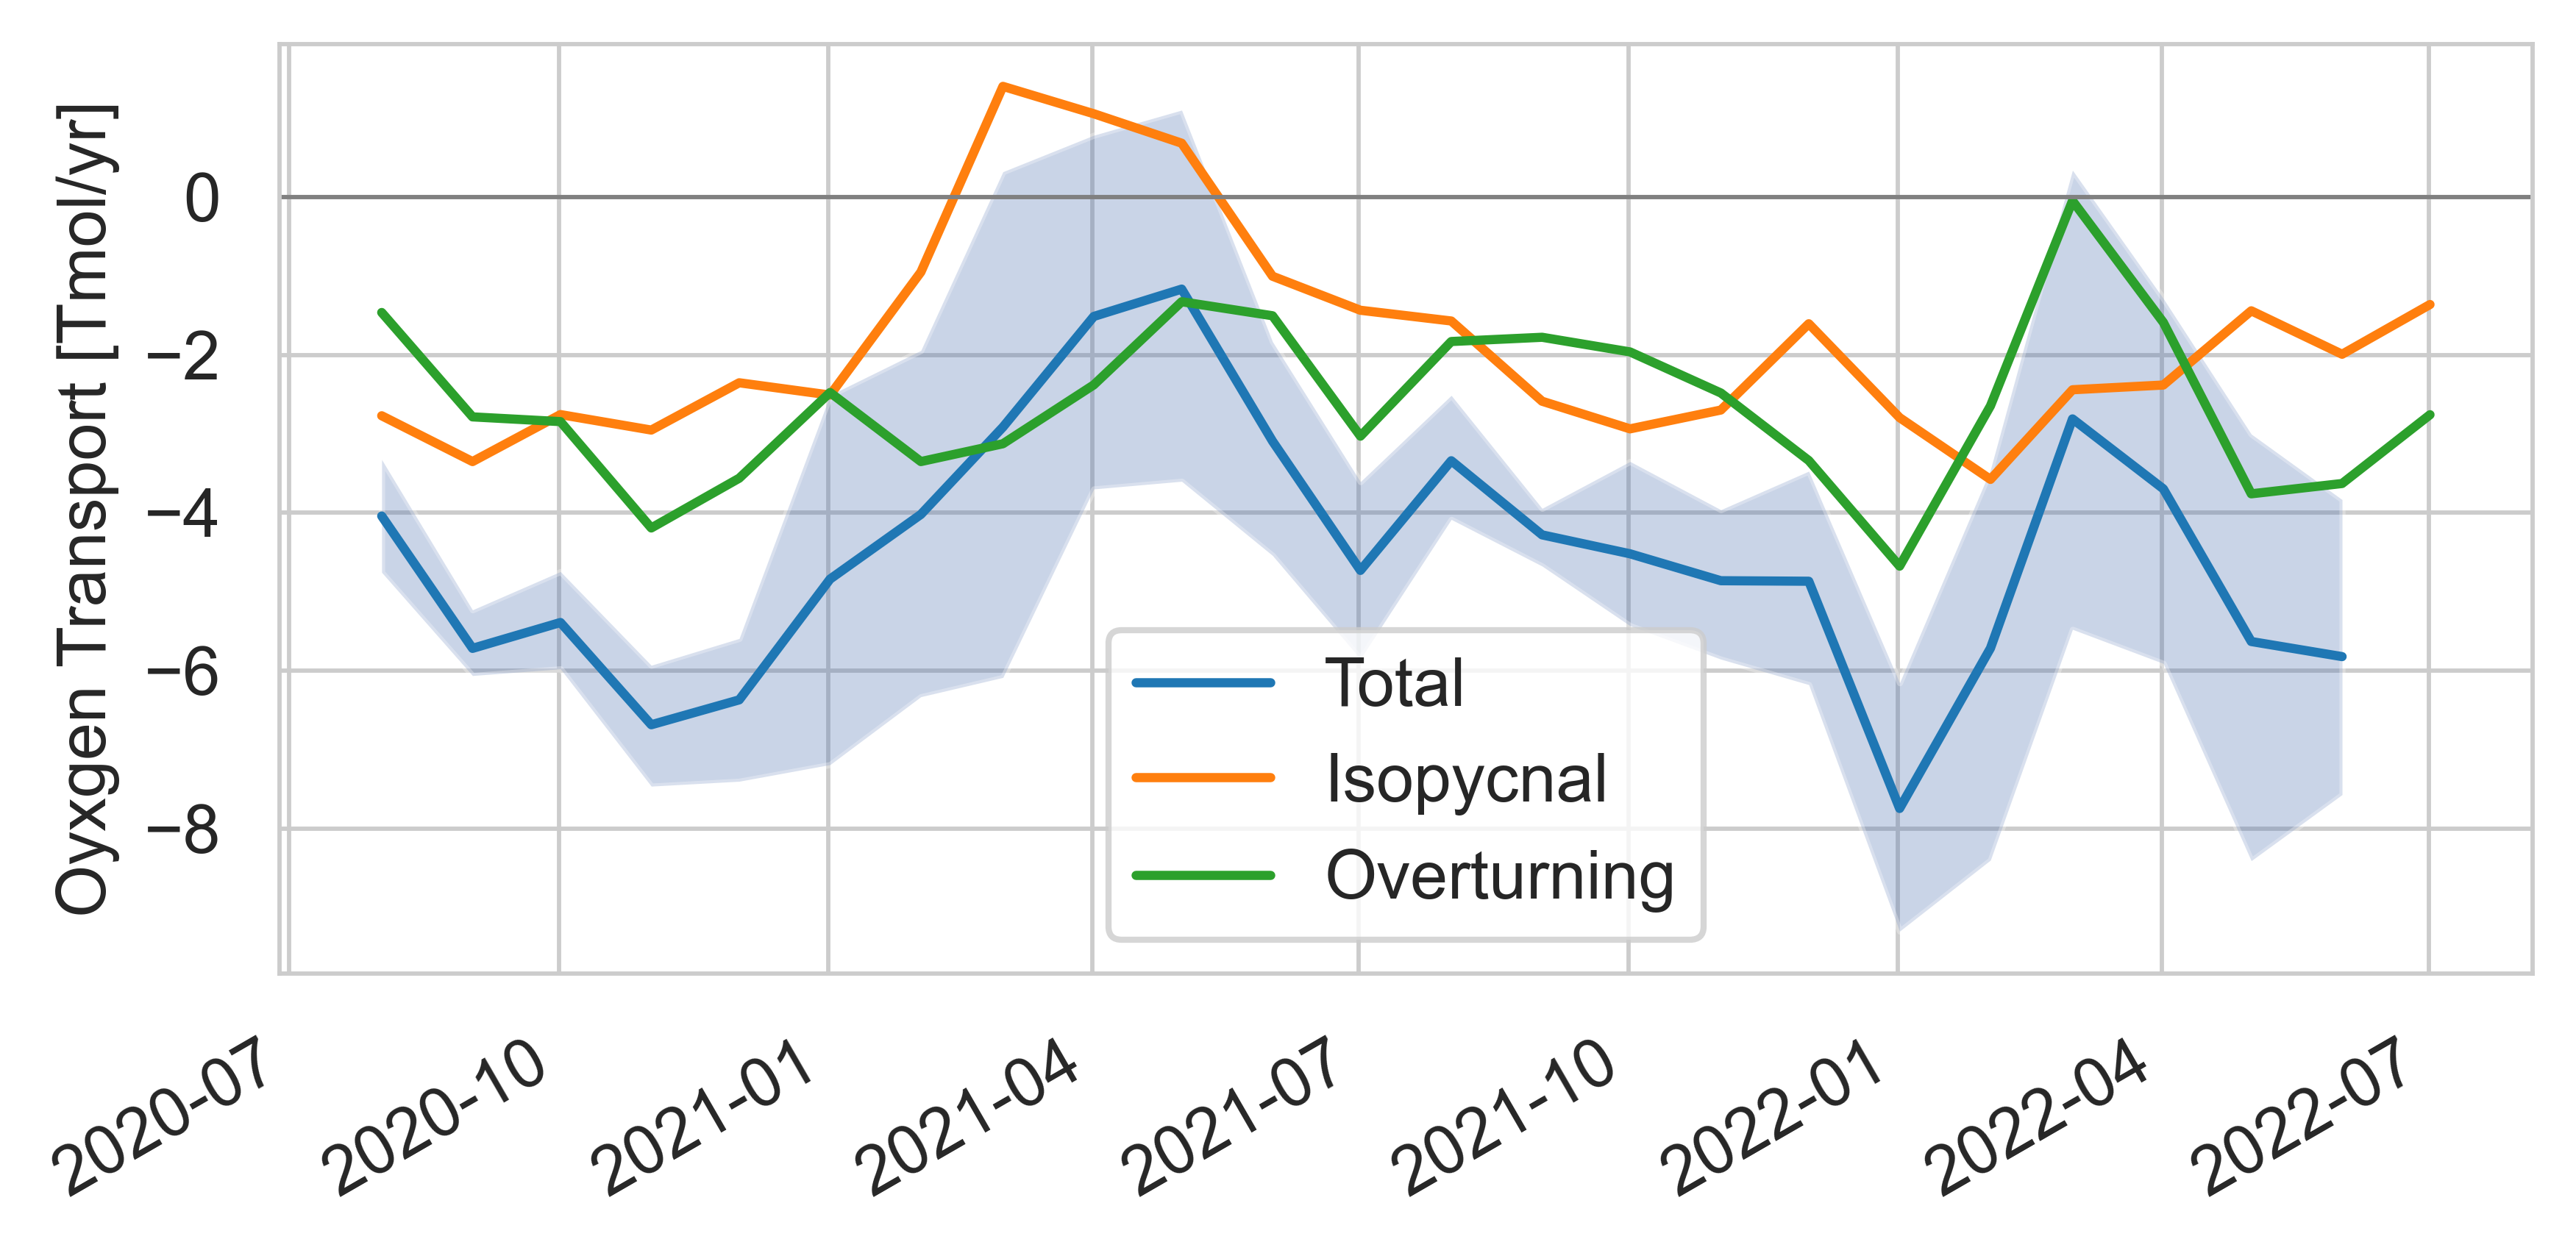

In [30]:
import matplotlib as mpl

mpl.rcParams['axes.linewidth'] = 0.7

plt.figure(figsize=(6, 3), dpi=600) 


plt.fill_between(osnap.TIME[:-1],np.nanmean(tmp2,axis = 0)[:-1] - np.nanstd(tmp2,axis = 0)[:-1], np.nanmean(tmp2,axis = 0)[:-1] + np.nanstd(tmp2,axis = 0)[:-1], alpha = 0.3)
# plt.fill_between(osnap.TIME[:-1],np.nanmean(tmp3,axis = 0)[:-1] - np.nanstd(tmp3,axis = 0)[:-1], np.nanmean(tmp3,axis = 0)[:-1] + np.nanstd(tmp3,axis = 0)[:-1], 
#                  edgecolor='none', linewidth=0, alpha = 0.3, zorder = 2)

#plt.plot(osnap.TIME[:-1],np.nanmean(tmp2,axis = 0)[:-1] , color ='tab:orange')

#plt.plot(osnap.TIME[:-1],np.nanmean(tmp2,axis = 0)[:-1], color='tab:orange' )
osnap.TIME[:-1],osnap.OXY_TRANSPORT.sum(dim = 'LONGITUDE').sum(dim='DEPTH')[:-1].plot( color = 'tab:blue', label = 'Total')

plt.ylabel('Oyxgen Transport [Tmol/yr]', fontsize = 11)

#[:-1] all months and last value of cumulative sum, which is the net total
# plt.fill_between(osnap.TIME,componants.isopycnal.mean(dim='realization').values[:,-1] - componants.isopycnal.std(dim='realization').values[:,-1], 
#                  componants.isopycnal.mean(dim='realization').values[:,-1] + componants.isopycnal.std(dim='realization').values[:,-1],alpha = 0.3)


plt.plot(osnap.TIME,componants.isopycnal.mean(dim='realization').values[:,-1], color = 'tab:orange', label = 'Isopycnal')

# plt.fill_between(osnap.TIME,componants.overturning.mean(dim='realization').values[:,-1] - componants.overturning.std(dim='realization').values[:,-1], 
#                  componants.overturning.mean(dim='realization').values[:,-1] + componants.overturning.std(dim='realization').values[:,-1],alpha = 0.3)


plt.plot(osnap.TIME,componants.overturning.mean(dim='realization').values[:,-1], color = 'tab:green', label = 'Overturning')
plt.axhline(0, color = 'grey', linewidth = 0.7)
plt.grid(linewidth=0.7)
plt.xlabel('')

plt.legend()

plt.tight_layout()



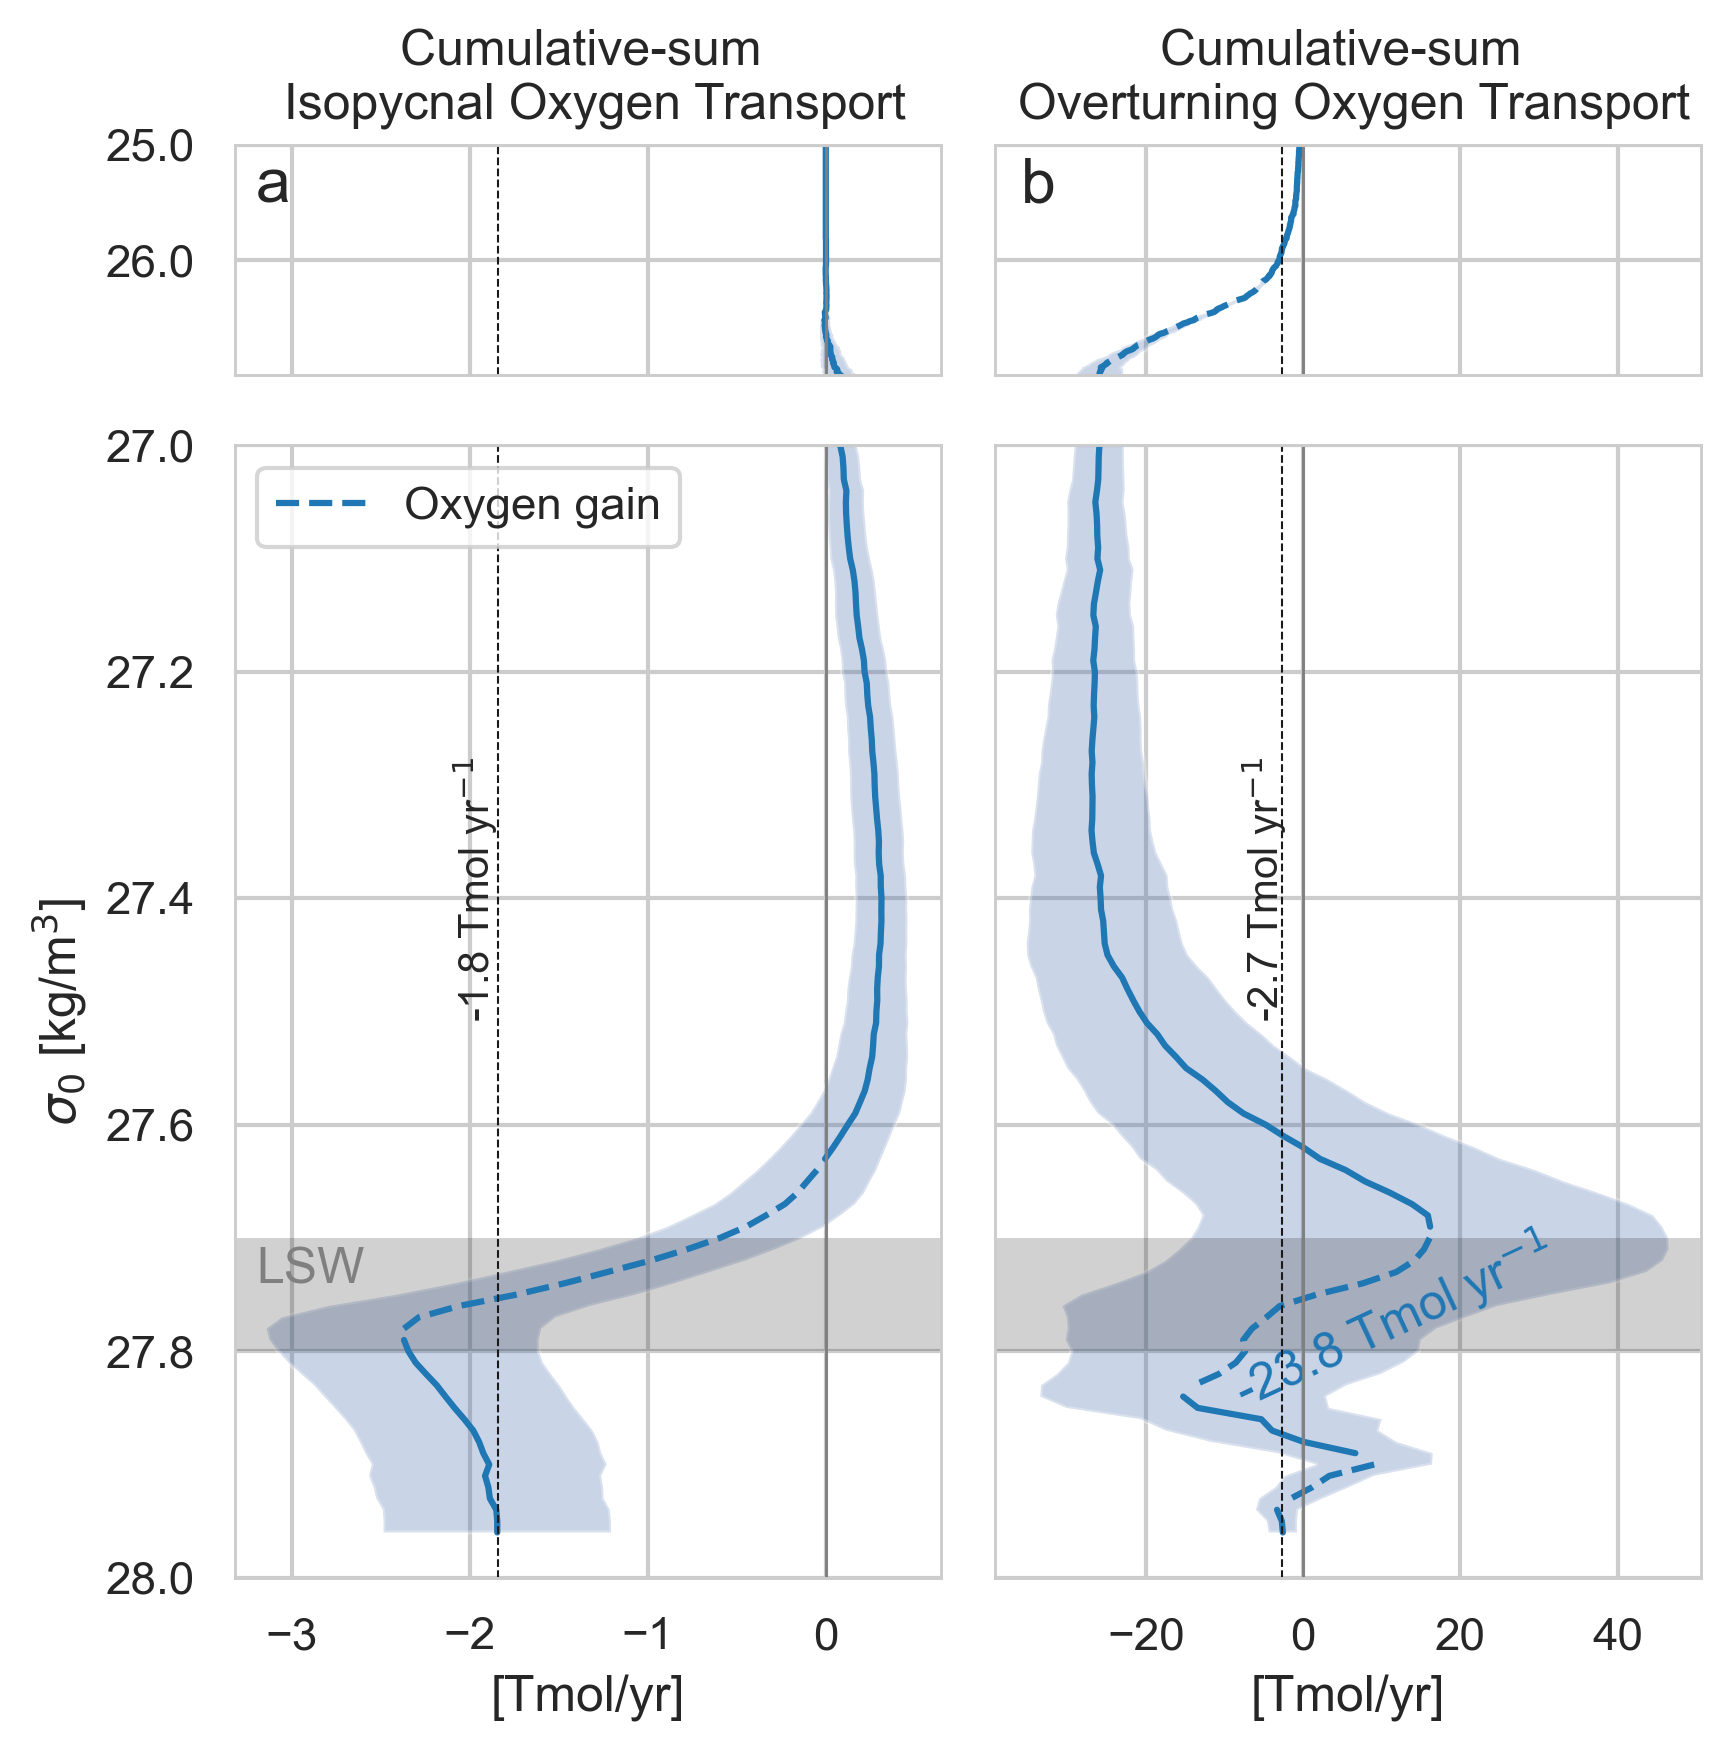

In [74]:
isopycnal_transport = componants.isopycnal.values
overturning_transport = componants.overturning.values

fig = plt.figure(figsize = ((6,6)), dpi = 300)

gs = gridspec.GridSpec(5, 4)
mpl.rcParams['axes.linewidth'] = 0.7

bins_rho0 = density = np.arange(1024.54, 1027.96, 0.01) - 1000


ax1 = fig.add_subplot(gs[0, 0:2])  ################################### top left


ax1.plot(np.nanmean(np.nanmean(isopycnal_transport,axis = 1),axis = 0), np.arange(1024.54, 1027.96, 0.01)-1000, color = 'tab:blue')


x1 = np.nanmean(np.nanmean(isopycnal_transport,axis = 1),axis = 0) - np.nanstd(np.nanmean(isopycnal_transport,axis = 1),axis = 0)
x2 = np.nanmean(np.nanmean(isopycnal_transport,axis = 1),axis = 0) + np.nanstd(np.nanmean(isopycnal_transport,axis = 1),axis = 0)
ax1.fill_betweenx(np.arange(1024.54, 1027.96, 0.01)-1000, x1, x2 , alpha = 0.3)



ax1.invert_yaxis()

ax1.set_ylim([27, 25])

ax1.set_yticks([26,25]) 
ax1.set_yticklabels([26.0,25.0])


ax1.set_xticklabels([])

#plt.axhline(27.69, color = 'k', linestyle = 'dashed', linewidth = 0.5)

#plt.grid()

ax1.axvline(0, color = 'grey', linewidth = 0.7)
# plt.axvline(-0.2)
# plt.axvline(-2.05)

ax1.set_title('Cumulative-sum \n Isopycnal Oxygen Transport')

#plt.text(-3.2, 27.08, 'a', fontsize = 15)

#ax1.set_ylabel('$\sigma _{0}$ [kg/m$^{3}$]')


ax2 = fig.add_subplot(gs[0, 2:4]) ################################### top right

ax2.set_title('Cumulative-sum \n Overturning Oxygen Transport')

#ax2.plot(np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0), np.arange(1024.54, 1027.96, 0.01)-1000, color = 'k', linestyle='dashed', label='0.01 kg/m3')
ax2.plot(np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0)[:150], np.arange(1024.54, 1027.96, 0.01)[:150]-1000, color = 'tab:blue')
ax2.plot(np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0)[150:], np.arange(1024.54, 1027.96, 0.01)[150:]-1000, color = 'tab:blue', linestyle = 'dashed')

x1 = np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0) - np.nanstd(np.nanmean(overturning_transport,axis = 1),axis = 0)
x2 = np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0) + np.nanstd(np.nanmean(overturning_transport,axis = 1),axis = 0)
ax2.fill_betweenx(np.arange(1024.54, 1027.96, 0.01)-1000, x1, x2 , alpha = 0.3 )


ax2.invert_yaxis()

#plt.legend(loc =1)
ax2.set_ylim([27, 25]) 

#plt.axhline(27.69, color = 'k', linestyle = 'dashed', linewidth = 0.5)

#plt.grid()

#plt.axhline(27.83, color = 'k', linestyle = 'dashed', linewidth = 0.5)
ax2.axvline(0, color = 'grey', linewidth = 0.7)

# plt.axvline(-26.297)
# plt.axvline(-8)
# plt.axvline(-15)
# plt.axvline(8)

ax2.set_yticks([26,25]) 

ax2.set_xticklabels([])
ax2.set_yticklabels([])
#plt.text(-36, 27.08, 'b', fontsize = 15)







ax3 = fig.add_subplot(gs[1:5, 0:2]) ################################## bottom left

#ax3.plot(np.nanmean(np.nanmean(isopycnal_transport,axis = 1),axis = 0), np.arange(1024.54, 1027.96, 0.01)-1000, color = 'k', label='0.01 kg/m3')
ax3.plot(np.nanmean(np.nanmean(isopycnal_transport,axis = 1),axis = 0)[:310], np.arange(1024.54, 1027.96, 0.01)[:310]-1000, color = 'tab:blue')
ax3.plot(np.nanmean(np.nanmean(isopycnal_transport,axis = 1),axis = 0)[310:325], np.arange(1024.54, 1027.96, 0.01)[310:325]-1000, color = 'tab:blue', linestyle='dashed', label = 'Oxygen gain')
ax3.plot(np.nanmean(np.nanmean(isopycnal_transport,axis = 1),axis = 0)[325:], np.arange(1024.54, 1027.96, 0.01)[325:]-1000, color = 'tab:blue')

x1 = np.nanmean(np.nanmean(isopycnal_transport,axis = 1),axis = 0) - np.nanstd(np.nanmean(isopycnal_transport,axis = 1),axis = 0)
x2 = np.nanmean(np.nanmean(isopycnal_transport,axis = 1),axis = 0) + np.nanstd(np.nanmean(isopycnal_transport,axis = 1),axis = 0)
ax3.fill_betweenx(np.arange(1024.54, 1027.96, 0.01)-1000, x1, x2, alpha = 0.3  )

ax3.invert_yaxis()

ax3.set_ylim([28, 27])

ax3.axhspan(27.7, 27.8, color = 'k', alpha = 0.2, lw=0) #27.69
#ax3.axhspan(27.8, 27.89, color = 'k', alpha = 0.2, lw=0)
#ax3.axhspan(27.89, 27.96, color = 'k', alpha = 0.3, lw=0)
#plt.axhline(27.69, color = 'k', linestyle = 'dashed', linewidth = 0.5)

#plt.grid()

ax3.axvline(0, color = 'grey', linewidth = 0.7)
# plt.axvline(-0.2)
# plt.axvline(-2.05)
ax3.set_xlabel('[Tmol/yr]')




ax3.set_ylabel('$\sigma _{0}$ [kg/m$^{3}$]')

ax3.legend()

ax4 = fig.add_subplot(gs[1:5, 2:4]) ################################## bottom right




#ax4.plot(np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0), np.arange(1024.54, 1027.96, 0.01)-1000, color = 'k', linestyle='dashed', label='0.01 kg/m3')

ax4.plot(np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0)[:316], np.arange(1024.54, 1027.96, 0.01)[:316]-1000, color = 'tab:blue')
ax4.plot(np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0)[316:330], np.arange(1024.54, 1027.96, 0.01)[316:330]-1000, color = 'tab:blue', linestyle='dashed')
ax4.plot(np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0)[330:336], np.arange(1024.54, 1027.96, 0.01)[330:336]-1000, color = 'tab:blue')
ax4.plot(np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0)[336:-3], np.arange(1024.54, 1027.96, 0.01)[336:-3]-1000, color = 'tab:blue',  linestyle='dashed')
ax4.plot(np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0)[-3:], np.arange(1024.54, 1027.96, 0.01)[-3:]-1000, color = 'tab:blue')


x1 = np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0) - np.nanstd(np.nanmean(overturning_transport,axis = 1),axis = 0)
x2 = np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0) + np.nanstd(np.nanmean(overturning_transport,axis = 1),axis = 0)
ax4.fill_betweenx(np.arange(1024.54, 1027.96, 0.01)-1000, x1, x2, alpha = 0.3  )


ax4.invert_yaxis()

#plt.legend(loc =1)

ax4.set_ylim([28, 27])
 
ax4.axhspan(27.7, 27.8, color = 'k', alpha = 0.2, lw=0) #27.69
#ax4.axhspan(27.8, 27.89, color = 'k', alpha = 0.2, lw=0)
#ax4.axhspan(27.89, 27.96, color = 'k', alpha = 0.3, lw=0)


#plt.axhline(27.69, color = 'k', linestyle = 'dashed', linewidth = 0.5)

#plt.grid()

#plt.axhline(27.83, color = 'k', linestyle = 'dashed', linewidth = 0.5)
ax4.axvline(0, color = 'grey', linewidth = 0.7)

# plt.axvline(-26.297)
# plt.axvline(-8)
# plt.axvline(-15)
# plt.axvline(8)

ax4.set_xlabel('[Tmol/yr]')



ax4.set_yticklabels([])

plt.tight_layout()
#fig.subplots_adjust(hspace=0.05, wspace=0.2, top=0.95, bottom=0.08, left=0.1, right=0.95)
#plt.subplots_adjust(hspace= 0.005)


ax1.text(-3.2, 25.5, 'a', fontsize = 15)
ax2.text(-36, 25.5, 'b', fontsize = 15)
ax3.text(-3.2, 27.74, 'LSW', fontsize = 12, color = 'grey')
#ax3.text(-2.1, 27.82, '+ 1.8 Tmol/yr', fontsize = 12, rotation=17)
#ax4.text(-5, 27.83, '-23.8 Tmol yr$^{-1}$', color = 'tab:blue',fontsize = 12,  rotation=25)
ax4.text(-10, 27.85, '-23.8 Tmol yr$^{-1}$', color = 'tab:blue',fontsize = 12,  rotation=25, zorder = 1)


ax1.axvline(-1.84, color = 'k', linewidth = 0.5, linestyle='dashed')
ax3.axvline(-1.84, color = 'k', linewidth = 0.5, linestyle='dashed')
ax3.text(-2.1, 27.5, '-1.8 Tmol yr$^{-1}$', rotation = 90, fontsize = 10)

ax2.axvline(-2.7, color = 'k', linewidth = 0.5, linestyle='dashed')
ax4.axvline(-2.7, color = 'k', linewidth = 0.5, linestyle='dashed')
ax4.text(-8, 27.5, '-2.7 Tmol yr$^{-1}$', rotation = 90, fontsize = 10)

plt.savefig(r'C:\Users\bikbe\Documents\Projects\GOHSNAP\Figures\Transport manuscript\iso_OT_cumsum.png')

### Calculate oxygen gain loss from cumulative-sum overturning plot

In [ ]:
a = np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0)[np.argwhere(np.isclose(np.arange(1024.54, 1027.96, 0.01), 1027.40))[0]]
b = np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0)[np.argwhere(np.isclose(np.arange(1024.54, 1027.96, 0.01), 1027.65))[0]]

b - a

array([31.28288603])

In [ ]:
a = np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0)[0]
b = np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0)[np.argwhere(np.isclose(np.arange(1024.54, 1027.96, 0.01), 1027.65))[0]]

b - a

array([5.39111566])

In [ ]:
a = np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0)[np.argwhere(np.isclose(np.arange(1024.54, 1027.96, 0.01), 1027.65))[0]]
b = np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0)[np.argwhere(np.isclose(np.arange(1024.54, 1027.96, 0.01), 1027.80))[0]]

b - a

array([-13.03981493])

In [ ]:
a = np.nanmean(overturning_transport,axis = 1)[:,np.argwhere(np.isclose(np.arange(1024.54, 1027.96, 0.01), 1027.65))[0]]
b = np.nanmean(overturning_transport,axis = 1)[:,np.argwhere(np.isclose(np.arange(1024.54, 1027.96, 0.01), 1027.80))[0]]

print(np.nanmean(b - a))

print(np.nanstd(b - a))

-13.039814934021638
1.535007649058575


In [ ]:
a = np.nanmean(overturning_transport,axis = 1)[:,np.argwhere(np.isclose(np.arange(1024.54, 1027.96, 0.01), 1027.7))[0]]
b = np.nanmean(overturning_transport,axis = 1)[:,np.argwhere(np.isclose(np.arange(1024.54, 1027.96, 0.01), 1027.80))[0]]

print(np.nanmean(b - a))

print(np.nanstd(b - a))

-23.7879634954878
6.9493774382763664


In [ ]:
a = np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0)[np.argwhere(np.isclose(np.arange(1024.54, 1027.96, 0.01), 1027.80))[0]]
b = np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0)[np.argwhere(np.isclose(np.arange(1024.54, 1027.96, 0.01), 1027.89))[0]]

b - a

array([7.68384278])

In [ ]:
a = np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0)[np.argwhere(np.isclose(np.arange(1024.54, 1027.96, 0.01), 1027.89))[0]]
b = np.nanmean(np.nanmean(overturning_transport,axis = 1),axis = 0)[-1]

b - a

array([-2.6392223])

In [ ]:
print(np.nanmean(np.nanmean(isopycnal_transport,axis = 0)[:,-1]))
print(np.nanmean(np.nanstd(isopycnal_transport,axis = 0)[:,-1]))

-1.8452316068797237
0.6385646864995117


In [ ]:
print(np.nanmean(np.nanmean(overturning_transport,axis = 0)[:,-1]))
print(np.nanmean(np.nanstd(overturning_transport,axis = 0)[:,-1]))

-2.6040787985776976
1.7974973643585834
